In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import cv2
import os
import glob

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')), " ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1   [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# tf.debugging.set_log_device_placement(False)
with tf.device('/GPU:0'):
  img_data = []
  for img in os.listdir("face_images"):
    img_file = cv2.imread("face_images/" + img)
    if(type(img_file) != type(None)):
      img_data.append(img_file)
  # img_data = tf.constant(img_data)

In [5]:
# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5
import random

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

# HORIZONTAL SHIFT - RANDOM RATIO 0 - 1
def horizontal_shift(img, ratio=0.0):
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

# VERTICAL SHIFT - RANDOM RATIO 0 - 1
def vertical_shift(img, ratio=0.0):
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img

# BRIGHTNESS - RANDOM LOW, HIGH 
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

# ZOOM - RANDOM VALUE 0 - 1
def zoom(img, value):
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

# HORIZONTAL FLIP - RANDOM BOOLEAN
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

# VERTICAL FLIP - RANDOM BOOLEAN
def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

# ROTATION - RANDOM ANGLE
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

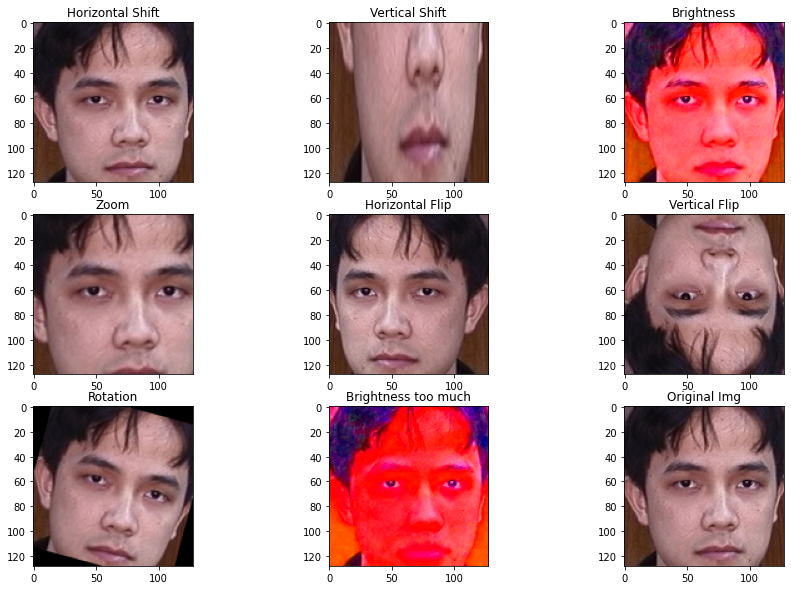

In [6]:
img_temp = cv2.imread("face_images/image00072.jpg")
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
img_aug_1 = horizontal_shift(img_temp, 0.6)
img_aug_2 = vertical_shift(img_temp, 0.7)
img_aug_3 = brightness(img_temp, 0.3, 5)
img_aug_4 = zoom(img_temp, 0.5)
img_aug_5 = horizontal_flip(img_temp, True)
img_aug_6 = vertical_flip(img_temp,True)
img_aug_7 = rotation(img_temp, 45)
img_aug_8 = brightness(img_temp, 0, 10)

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7, ax8, ax9)) = plt.subplots(nrows=3,ncols=3,figsize=(15,10))

ax1.imshow(img_aug_1)
ax1.set_title("Horizontal Shift")
ax2.imshow(img_aug_2)
ax2.set_title("Vertical Shift")
ax3.imshow(img_aug_3)
ax3.set_title("Brightness")
ax4.imshow(img_aug_4)
ax4.set_title("Zoom")
ax5.imshow(img_aug_5)
ax5.set_title("Horizontal Flip")
ax6.imshow(img_aug_6)
ax6.set_title("Vertical Flip")
ax7.imshow(img_aug_7)
ax7.set_title("Rotation")
ax8.imshow(img_aug_8)
ax8.set_title("Brightness too much")
ax9.imshow(img_temp)
ax9.set_title("Original Img")

plt.show()


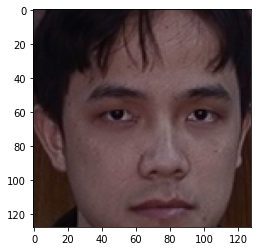

In [7]:
def scale(img, value):
  return np.array((value * img), dtype=np.uint8)

plt.imshow(scale(img_temp, 0.6))
plt.show()

In [8]:
with tf.device('/GPU:0'):
  img_augmented_data = []
  for i in img_data:
    img_augmented_data.append(i)
    for j in range(3):
      img_augmented_data.append(horizontal_shift(i, random.uniform(0, 1)))
      img_augmented_data.append(vertical_shift(i, random.uniform(0, 1)))
      img_augmented_data.append(zoom(i, random.uniform(0, 1)))
      img_augmented_data.append(scale(i, random.uniform(0.6, 1)))

In [9]:
img = cv2.cvtColor(img_augmented_data[0], cv2.COLOR_BGR2RGB)
imageLAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
L, a, b = cv2.split(imageLAB)

In [10]:
a_scaled = np.uint8(255.*(a - a.min())/(a.max() - a.min()))
b_scaled = np.uint8(255.*(b - a.min())/(b.max() - b.min()))

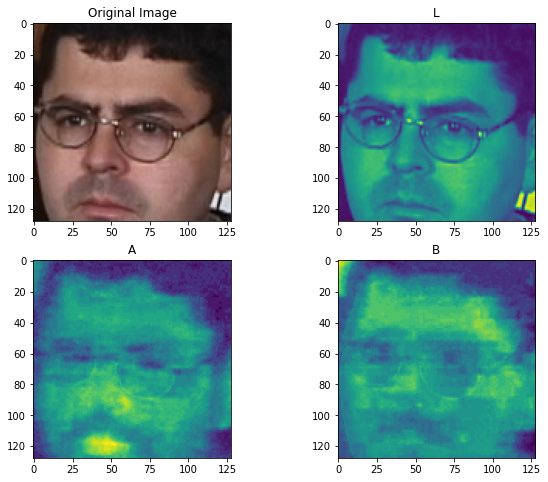

In [11]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

ax1.imshow(img)
ax1.set_title("Original Image")
ax2.imshow(L)
ax2.set_title("L")
ax3.imshow(a)
ax3.set_title("A")
ax4.imshow(b)
ax4.set_title("B")
plt.show()

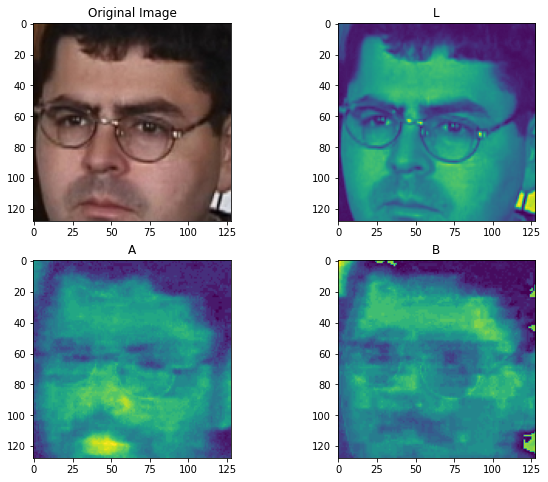

In [12]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

ax1.imshow(img)
ax1.set_title("Original Image")
ax2.imshow(L)
ax2.set_title("L")
ax3.imshow(a_scaled)
ax3.set_title("A")
ax4.imshow(b_scaled)
ax4.set_title("B")
plt.show()

In [13]:
L_data = []
a_data = []
b_data = []
count = 0
for img in img_augmented_data:
  imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  L, a, b = cv2.split(imageLAB)
  L_data.append(L)
  a_data.append(a)
  b_data.append(b)
  # cv2.imwrite("augmented_dataset/aug/imageaug" + str(count) + ".jpg", img)
  # cv2.imwrite("augmented_dataset/augLab/imageaugLab" + str(count) + ".jpg", imageLAB)
  # cv2.imwrite("augmented_dataset/aug_L/imageaugL" + str(count) + ".jpg", L)
  # cv2.imwrite("augmented_dataset/aug_a/imageauga" + str(count) + ".jpg", a)
  # cv2.imwrite("augmented_dataset/aug_b/imageaugb" + str(count) + ".jpg", b)
  count += 1

In [14]:
# !zip -r "augmented_data.zip" "augmented_dataset"

In [15]:
# from google.colab import files
# files.download("augmented_data.zip")

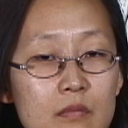

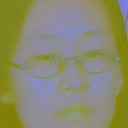

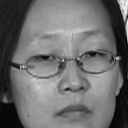

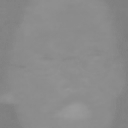

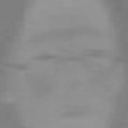

In [16]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread("face_images/image00004.jpg")
imageLAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
cv2_imshow(image)
cv2_imshow(imageLAB)
L,a,b=cv2.split(imageLAB)
cv2_imshow(L)
cv2_imshow(a)
cv2_imshow(b)

In [17]:
with tf.device('/GPU:0'):
  X_data = np.array(L_data, dtype = np.uint8)
  X_data = X_data / 255
  print(X_data.shape , np.amax(X_data))

(9750, 128, 128) 0.996078431372549


In [18]:
with tf.device('/GPU:0'):
  y_data = []
  a_mean = []
  b_mean = []
  for i in range(len(a_data)):
    y_data.append([np.average(a_data[i]), np.average(b_data[i])])
    a_mean.append(np.average(a_data[i]))
    b_mean.append(np.average(b_data[i]))
  y_data = np.array(y_data, dtype = np.float32)
  y_data = y_data / 255
  print(y_data.shape, np.amax(y_data))

(9750, 2) 0.61116415


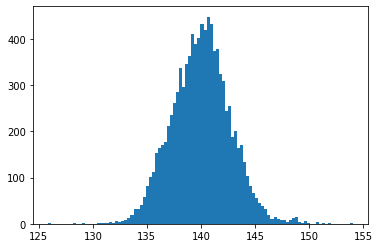

In [19]:
plt.hist(a_mean, bins=100)
plt.show()

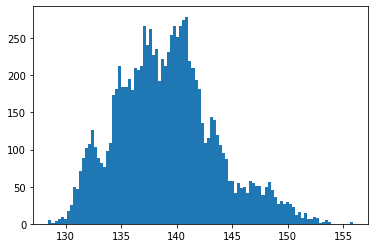

In [20]:
plt.hist(b_mean, bins=100)
plt.show()

In [21]:
import random
train_indices = []
for i in range(7800):
  x = random.randint(0, 9749)
  while(x in train_indices):
    x = random.randint(0, 9749)
  train_indices.append(x)
print(len(train_indices))
train_indices = list(set(train_indices))
print(len(train_indices))

7800
7800


In [22]:
tf.debugging.set_log_device_placement(False)
with tf.device('/GPU:0'):
  X_train = []
  X_test = []
  y_train = []
  y_test = []

  for i in range(9750):
    if(i in train_indices):
      X_train.append(X_data[i])
      y_train.append(y_data[i])
    else:
      X_test.append(X_data[i])
      y_test.append(y_data[i])

  X_train = tf.convert_to_tensor(X_train, dtype=np.float32)
  X_test = tf.convert_to_tensor(X_test, dtype=np.float32)
  y_train = tf.convert_to_tensor(y_train, dtype=np.float32)
  y_test= tf.convert_to_tensor(y_test, dtype=np.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([7800, 128, 128]),
 TensorShape([1950, 128, 128]),
 TensorShape([7800, 2]),
 TensorShape([1950, 2]))

In [23]:
X_train = tf.reshape(X_train, (7800, 1 , 128, 128))
X_test = tf.reshape(X_test, (1950, 1, 128, 128))
X_train.shape, X_test.shape

(TensorShape([7800, 1, 128, 128]), TensorShape([1950, 1, 128, 128]))

In [24]:
y_train = tf.reshape(y_train, (7800, 1, 1, 2))
y_test = tf.reshape(y_test, (1950, 1, 1, 2))
y_train.shape, y_test.shape

(TensorShape([7800, 1, 1, 2]), TensorShape([1950, 1, 1, 2]))

In [25]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D

# tf.debugging.set_log_device_placement(False)
with tf.device('/GPU:0'):
  model = Sequential()
  model.add(Input(shape = (X_train[0].shape)))
  model.add(Conv2D(64, 2, activation = "relu",strides = 2,padding = 'same', input_shape=X_train.shape[1:]))
  model.add(Conv2D(32, 2, activation = "relu",strides = 2,padding = 'same', input_shape=X_train.shape[1:]))
  model.add(Conv2D(16, 2, activation = "relu",strides = 2,padding = 'same', input_shape=X_train.shape[1:]))
  model.add(Conv2D(8, 2, activation = "relu",strides = 2,padding = 'same', input_shape=X_train.shape[1:]))
  model.add(Conv2D(4, 2, activation = "relu",strides = 2,padding = 'same', input_shape=X_train.shape[1:]))
  model.add(Conv2D(2, 2, activation = "relu",strides = 2,padding = 'same', input_shape=X_train.shape[1:]))
  model.add(Conv2D(2, 2, activation = "relu",strides = 2,padding = 'same', input_shape=X_train.shape[1:]))
  model.add(Dense(2,activation='relu'))
  # model.add(Dense(1,activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 64, 64)         32832     
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 32, 32)         8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 16, 16)         2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 8, 8)           520       
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 4, 4)           132       
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 2, 2)           34        
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 2)           1

In [26]:
with tf.device('/GPU:0'):
  loss = tf.keras.losses.MeanSquaredError(name='mean_squared_error')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss=loss)

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

with tf.device('/GPU:0'):
  lrr = ReduceLROnPlateau(monitor='val_loss', 
                          patience=5, 
                          verbose=1, 
                          factor=0.4, 
                          min_lr=0.0001)

In [28]:
history = model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test), 
                      epochs=50, 
                      batch_size=512,
                      steps_per_epoch=X_train.shape[0]//512,
                      validation_steps=X_test.shape[0]//512,
                      callbacks=[lrr],
                      shuffle=True)

Epoch 1/50
15/15 [==============================] - 13s 65ms/step - loss: 0.2764 - val_loss: 0.2375 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 1s 36ms/step - loss: 0.1864 - val_loss: 0.1678 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.1529 - val_loss: 0.1442 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 0s 30ms/step - loss: 0.1363 - val_loss: 0.1289 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 0s 29ms/step - loss: 0.1232 - val_loss: 0.1166 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.1115 - val_loss: 0.1057 - lr: 0.0010
Epoch 7/50
15/15 [==============================] - 0s 30ms/step - loss: 0.1015 - val_loss: 0.0960 - lr: 0.0010
Epoch 8/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0921 - val_loss: 0.0870 - lr: 0.0010
Epoch 9/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0834 - val_loss: 0.0788 - lr

In [29]:
for i in range(10):
  r = random.randint(0, 1949)
  pred = model.predict(tf.reshape(X_test[r],(1,1,128,128)))
  a = pred[0][0][0][0] * 255
  b = pred[0][0][0][1] * 255
  a_real = y_test[r][0][0][0] * 255
  b_real = y_test[r][0][0][1] * 255
  # print(model.predict(X_test[r].reshape(1,1,128,128)) , y_test[r])
  print(a_real.numpy(), " --- ", a)
  print(b_real.numpy(), " --- ", b)

1/1 [==============================] - 0s 211ms/step
136.30896  ---  141.38735800981522
138.71051  ---  138.89636367559433
1/1 [==============================] - 0s 17ms/step
140.15686  ---  141.21843427419662
138.09473  ---  138.83258789777756
1/1 [==============================] - 0s 15ms/step
140.6933  ---  140.46058773994446
136.65057  ---  138.5464784502983
1/1 [==============================] - 0s 21ms/step
140.27051  ---  142.76061952114105
138.36157  ---  139.41482305526733
1/1 [==============================] - 0s 18ms/step
139.85138  ---  137.8762400150299
138.86694  ---  137.5707972049713
1/1 [==============================] - 0s 17ms/step
143.90881  ---  140.34701943397522
141.67438  ---  138.5036015510559
1/1 [==============================] - 0s 16ms/step
139.01947  ---  139.33505773544312
135.00116  ---  138.12155485153198
1/1 [==============================] - 0s 17ms/step
140.02875  ---  141.37150526046753
143.6737  ---  138.89039039611816
1/1 [========================

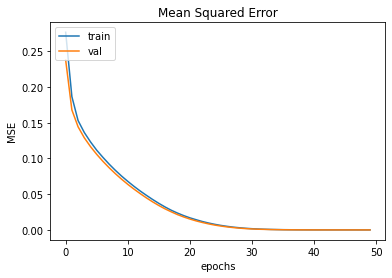

In [30]:
# PLOTTING THE ACCURACY AND VALIDATION ACCURACY VS EPOCHS
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
model.save("mean_chrominance_model.h5")

In [32]:
model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 5ms/step - loss: 1.8248e-04


0.0001824833598220721